# Outlier Treatment by Deleting them, Replacing them (mean) or instead changing the values to a fixed upper or lower boundry range  

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

As our dataset we will use the WORLD-OWID-Features dataset, which I extracted from the normal WORLD-OWID dataset.

you can see the feature engineering in the following notebook. sharable link: http://localhost:8888/lab/tree/Feature%20engineering.ipynb

In [2]:
df3 = pd.read_csv('WORLD-OWID-Features')

In [3]:
features_to_keep = ['co2', 'year', 'population', 'gdp', 'cement_co2', 'primary_energy_consumption', 'share_global_cumulative_gas_co2', 'share_global_cumulative_coal_co2', 'share_global_cumulative_flaring_co2', 'share_global_cumulative_oil_co2']

df3 = df3[features_to_keep]

KeyError: "['population', 'gdp', 'primary_energy_consumption', 'share_global_cumulative_gas_co2', 'share_global_cumulative_coal_co2', 'share_global_cumulative_flaring_co2', 'share_global_cumulative_oil_co2'] not in index"

In [ ]:
df3.describe()

# Creating Diagnostic Plots 

In [4]:
def plotvariable(df, variable):
    plt.figure(figsize=(16, 4))
    # Histogram 
    plt.subplot(1,2,1)
    plt.hist(df[variable], alpha=0.5)

    # Boxplot 
    plt.subplot(1,2,2)
    sns.boxplot(df[variable])
    plt.show

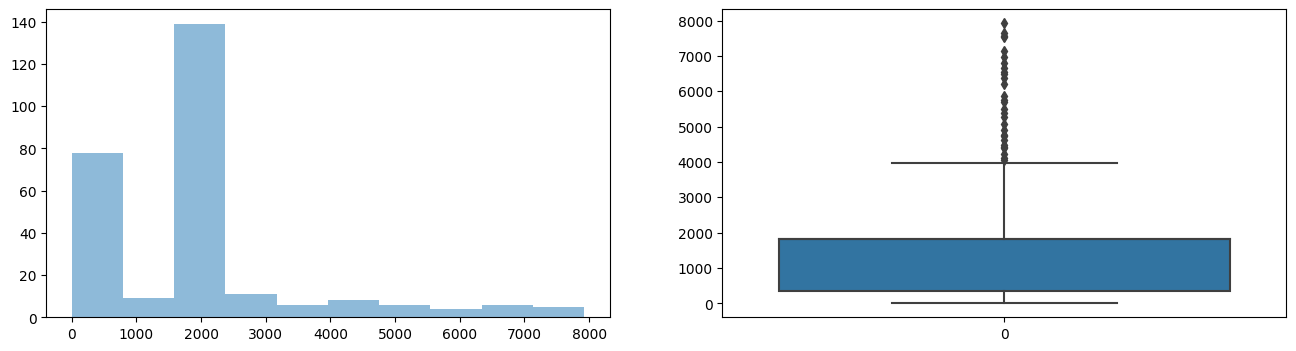

In [5]:
plotvariable(df3, 'gas_co2')

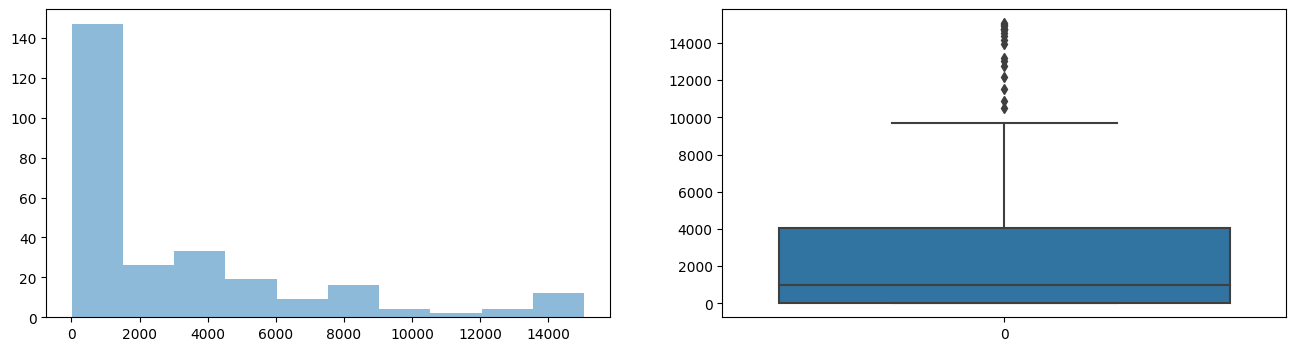

In [6]:
plotvariable(df3, 'coal_co2')

# Searching for the upper and lower band

In [7]:
def find_boundaries(df, variables):
    
    # Calculating our IQR (inter quantile range) 
    q1 = df[variables].quantile(.25)
    q3 = df[variables].quantile(.98)
    
    iqr = q3 - q1
    
    # deciding our lower band
    lower_boundry = q1 - 1.5 * iqr # Anything below our boundry = outlier 
    
    # Upper band 
    upper_boundry = q3 + 1.5 * iqr # Anything above '' ''
    
    return lower_boundry, upper_boundry

In [8]:
lower_boundry, upper_boundry = find_boundaries(df3, 'gas_co2')
print(f"Upper boundary = {upper_boundry}")
print(f"Lower boundary = {lower_boundry}")

Upper boundary = 16729.29799999999
Lower boundary = -9493.609999999995


With 'share_global_cumulative_gas_co2' as example, as we can see in the boxplot above all of the values are below 10-20 exept for a few values that are above 80. 

These are extreme outliers that will defintely affect our models performance. 

# Threating our outliers 

There are different techniques to handle our outliers:
- We could remove them
- We could convert our outliers to the values of the upper and lower bands
- We could replace our outliers with the mean of the feature 

# Trough Removal 

In [ ]:
# deleting our outliers by excluding all the points above upper_boundry or below lower_boundry 

# A similar technique will be showed in percentale removing 

outliers = np.where(df3['gas_co2'] > upper_boundry, True , np.where(df3['gas_co2'] < lower_boundry, True, False))

outliers

In [10]:
df3['gas_co2'].shape

(272,)

In [11]:
# engineered_df = df3['share_global_cumulative_gas_co2'].loc[~(outliers),]

In [12]:
engineered_df = df3.loc[~(outliers),]

In [13]:
engineered_df.shape

(272, 9)

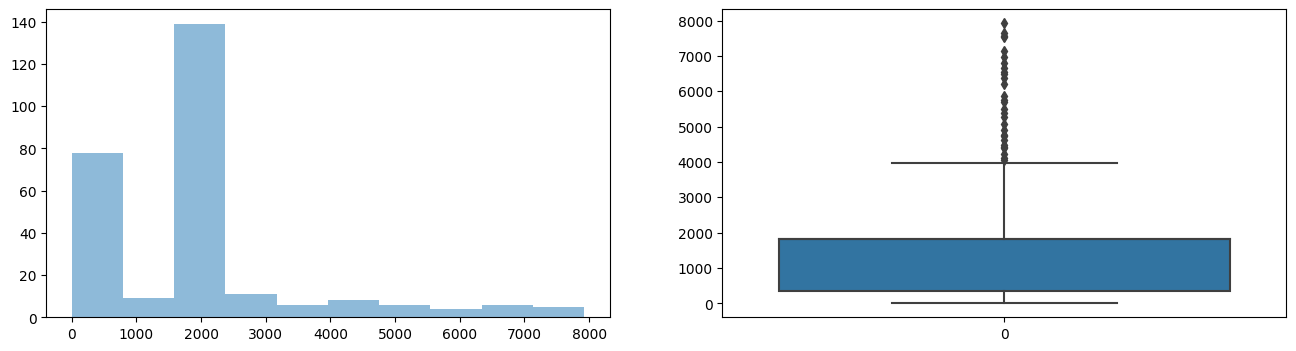

In [14]:
plotvariable(engineered_df, 'gas_co2')

As you can see, we now can visualize our data much better because it is not compressed anymore because of the outliers 

# Outlier Detection Using Percentale Removing and IsolationForest

# IsolationForest 

In [15]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest 

In [18]:
df = pd.read_csv('WORLD-OWID-Features')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 272 non-null    int64  
 1   cement_co2           272 non-null    float64
 2   co2                  272 non-null    float64
 3   coal_co2             272 non-null    float64
 4   flaring_co2          272 non-null    float64
 5   gas_co2              272 non-null    float64
 6   land_use_change_co2  272 non-null    float64
 7   oil_co2              272 non-null    float64
 8   other_industry_co2   272 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 19.3 KB


# Scaling data

In [ ]:
#from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler()

#df = scaler.fit_transform(df[!!])

In [ ]:
df

In [ ]:
df.head()

# Building Isolation Forest Model (2 & more Features)

In [20]:
anomaly_inputs = ['co2', 'cement_co2', 'gas_co2', 'coal_co2', 'flaring_co2', 'land_use_change_co2', 'other_industry_co2', 'oil_co2'] 

In [21]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()

# Selecting our columns for scaling 
#subset_columns = df[anomaly_inputs]

# Scale the selected columns and assign the scaled values back to the DataFrame
#df[anomaly_inputs] = scaler.fit_transform(subset_columns)

In [22]:
# Contamination: deciding what percentage of our max and min range at the both sides should be removed as anomalies 

Model_IF = IsolationForest(contamination=0.1, random_state=42)

In [23]:
Model_IF.fit(df[anomaly_inputs])  

IsolationForest(contamination=0.1, random_state=42)

In [24]:
# Creating an anomaly scores column 
df['Anomaly_scores'] = Model_IF.decision_function(df[anomaly_inputs])

In [25]:
# Exclude the last new created column because shapes must be the same 

#df['anomaly'] = Model_IF.predict(df.iloc[:, :-1]) # output in column -> 1 = normal, -1 = abnormal/anomaly
df['anomaly'] = Model_IF.predict(df[anomaly_inputs])


In [26]:
def outlier_plot(data, outlier_method_name, x_var, y_var, xaxis_limits=[0.05], yaxis_limits = [0,1]):
    print(outlier_method_name)

    print(f"Number of anomaly values {len(data[data['anomaly']== -1])}")
    print(f"Number of 'normal' values {len(data[data['anomaly']== 1])}")
    print(f"Total = {len(data)}")

    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1,-1])
    g.map(sns.scatterplot, x_var, y_var)
    g.fig.suptitle(f"Outlier method:", y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outlier\n{len(df[df['anomaly']== -1])} points")
    axes[1].set_title(f"Normals\n{len(df[df['anomaly']== 1])} points")
    return g

In [27]:
print(f"Number of anomaly values {len(df[df['anomaly']== -1])}")
print(f"Number of 'normal' values {len(df[df['anomaly']== 1])}")
print(f"Total = {len(df)}")

Number of anomaly values 28
Number of 'normal' values 244
Total = 272


In [28]:
df.loc[:, ['anomaly', 'Anomaly_scores']]

,anomaly,Anomaly_scores
0,1,0.216467
1,1,0.216467
2,1,0.216467
3,1,0.216467
4,1,0.215772
...,...,...
267,-1,-0.027252
268,-1,-0.045654
269,-1,-0.080542
270,-1,-0.074582


# Visualization 

In [ ]:
# outlier_plot(df, "Isolation Forest", "population", "primary_energy_consumption", [0, 0.9], [1, 3]);

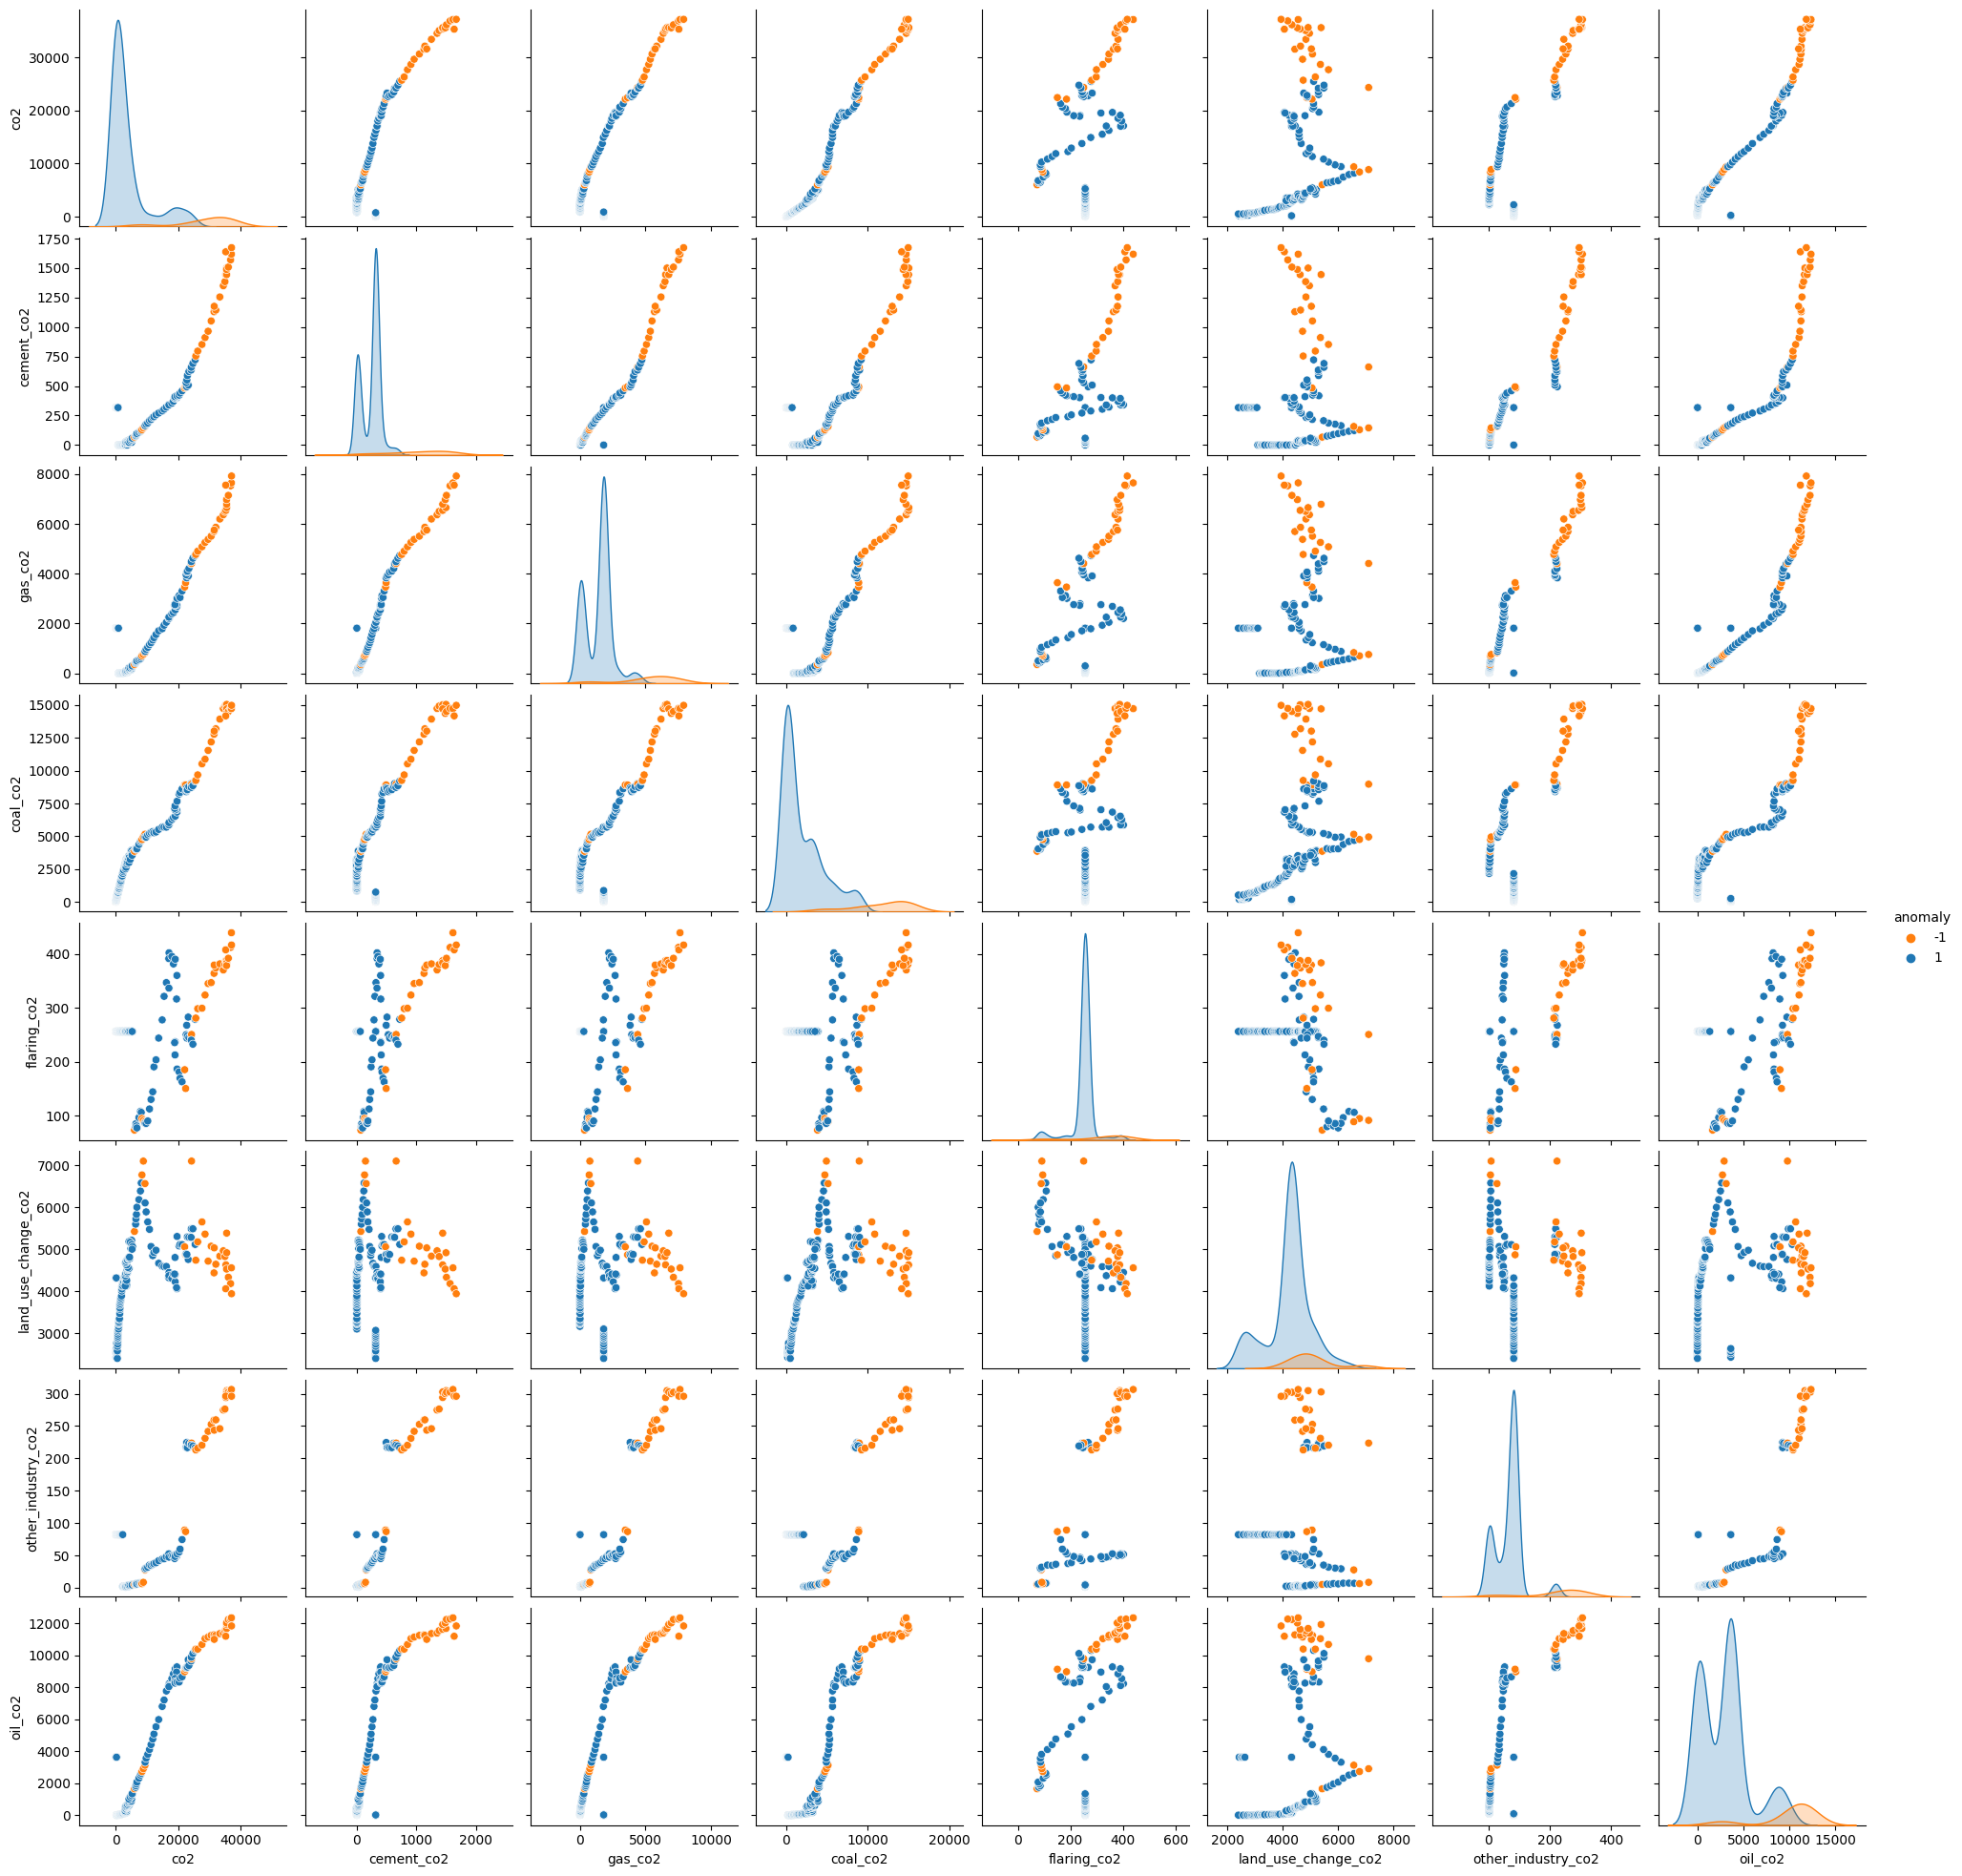

In [29]:
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(df, vars=anomaly_inputs, hue='anomaly', palette=palette)

In [ ]:
import matplotlib.pyplot as plt

numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Bepaal het aantal rijen en kolommen voor de subplots
num_rows = 4
num_cols = 2

# Bereken het totale aantal subplots
total_subplots = len(numeric_columns)

# Maak meerdere beelden met subplots om alle numerieke kolommen weer te geven
for i in range(0, total_subplots, num_rows*num_cols):
    plt.figure(figsize=(15, 5*num_rows))
    for j, col in enumerate(numeric_columns[i:i+num_rows*num_cols]):
        plt.subplot(num_rows, num_cols, j + 1)
        plt.boxplot(df[col])
        plt.title(col)
        plt.tight_layout()

        plt.legend(labels=['Outliers'])

    plt.show()

# Removal Using Percentale

In [30]:
df2 = pd.read_csv('WORLD-OWID-Features')
df2.shape

(272, 9)

# Percental Removal

In [31]:
min_threshold, max_threshold = df2.cement_co2.quantile([0.01, 0.999])
min_threshold, max_threshold

(0.0, 1663.0920950000016)

In [32]:
df2[df2.cement_co2>max_threshold]

,year,cement_co2,co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,other_industry_co2
271,2021,1672.592,37123.852,14979.598,416.526,7921.83,3939.044,11837.159,296.146


In [33]:
df2[df2.cement_co2<min_threshold]

,year,cement_co2,co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,other_industry_co2


In [34]:
# Switching the ranges operators the take the part of data without anomelies

df2 = df2[(df2.cement_co2<max_threshold) & (df2.cement_co2>min_threshold)]
df2.sample(10)

,year,cement_co2,co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,other_industry_co2
50,1800,317.372711,28.092,28.092,256.309556,1814.698707,4316.805465,3625.609168,82.069576
70,1820,317.372711,50.688,50.688,256.309556,1814.698707,4316.805465,3625.609168,82.069576
173,1923,0.208000,3675.398,3146.423,256.309556,52.526000,4433.685000,473.527000,2.714000
162,1912,0.177000,3235.538,3047.940,256.309556,28.315000,4247.797000,156.759000,2.347000
28,1778,317.372711,15.044,15.044,256.309556,1814.698707,4316.805465,3625.609168,82.069576
237,1987,459.192000,21273.904,8617.361,163.007000,3305.280000,5112.868000,8654.659000,74.406000
230,1980,402.620000,19501.264,7024.129,316.436000,2758.101000,4084.627000,8951.775000,48.202000
203,1953,89.628000,6647.763,4043.705,81.348000,474.527000,5832.111000,1952.100000,6.455000
165,1915,0.160000,3134.378,2902.827,256.309556,31.866000,4183.311000,197.104000,2.421000
268,2018,1569.218000,36826.508,14746.831,412.116000,7529.847000,4181.356000,12266.017000,302.479000


In [35]:
df2.shape

(264, 9)